In [1]:
import sys
# sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
sys.path.append('/workspaces/eth-capstone-treewater-deficit/src')
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import StandardScaler
from treewater.utils import *

2025-12-16 19:26:30.122678: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 19:26:55.672970: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 19:27:05.512984: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
import importlib
import treewater.utils as utils
importlib.reload(utils)

# check presence
print(hasattr(utils, "build_autoregressive_training_data_fast_LSTM_scheduled"))
print(hasattr(utils, "teacher_forcing_prob"))
print(hasattr(utils, "cross_validation_LSTM_FT"))

True
True
True


In [3]:
# set global random seed
seed = 66666
tf.random.set_seed(
    seed
)

In [4]:
# # At top of notebook
# %load_ext autoreload
# %autoreload 2

# from treewater.utils import *

In [5]:
# derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
# data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
data_dir = "/workspaces/eth-capstone-treewater-deficit/data/tstoy04"
derived_path = "/workspaces/eth-capstone-treewater-deficit/data"

In [6]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [7]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [8]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [9]:
# twd_tree_series_sites

In [10]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [11]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [12]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1e-6
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [13]:
# Configure features
config = FeatureConfig()
lag_n =13

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = create_training_test_set_optimized(
    df_series_features,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)





2025-12-16 19:27:08.724058: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### build LSTM
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [14]:

batch_size = 64
lag_n = 13

### Autoregressive
- reduce hidden space size to prevent overfitting

In [15]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    

In [16]:
# dynamic input
def build_autoregressive_model_lstm( train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, hidden_unit = 16):
     # we don't actually need the input features but rather the shape information
    timesteps = lag_n
    n_features = train_X_ts_at.shape[2] # include TWD + other variables

    dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")
    x_dyn = tf_keras.layers.LSTM(hidden_unit, return_sequences=False)(dyn_in)
    x_dyn = tf_keras.layers.Dense(hidden_unit, activation="relu")(x_dyn)

    # current day other features
    n_static = train_day_feat_X.shape[1]
    static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
    x_static = tf_keras.layers.Dense(4, 
                                     activation="relu",
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                     )(static_in)

    # static input
    n_current = train_static_X_ts.shape[1]
    curr_in = tf_keras.Input(shape=(n_current,), name="static")
    x_curr = tf_keras.layers.Dense(4, 
                                   activation="relu",
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                   )(curr_in)


    combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
    x = tf_keras.layers.Dense(16, activation="relu")(combined)
    out = tf_keras.layers.Dense(1, activation = "softplus")(x)


    model_at = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
    )

    model_at.compile(
        optimizer=tf_keras.optimizers.Adam(),
        loss="mse",
        metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
    )
    return model_at

In [17]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    



In [18]:
# create two models with different hidden units 

model_fold1 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = 16)
maes_cv_at, rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = cross_validation_LSTM(
    model_fold1,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size
)

model_fold2 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at , lag_n, hidden_unit = 32)
maes_cv_at2, rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2, y_preds_cv_at2, y_trues_cv_at2, historys_cv_at2  = cross_validation_LSTM(
    model_fold2,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size
)


Training fold 1/4
Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.7659 - mae: 0.5908 - rmse: 0.8687 - val_loss: 0.5577 - val_mae: 0.5220 - val_rmse: 0.7394
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6333 - mae: 0.5303 - rmse: 0.7890 - val_loss: 0.5720 - val_mae: 0.4992 - val_rmse: 0.7492
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5179 - mae: 0.4763 - rmse: 0.7123 - val_loss: 0.5760 - val_mae: 0.4863 - val_rmse: 0.7520
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3949 - mae: 0.4103 - rmse: 0.6201 - val_loss: 0.5382 - val_mae: 0.4695 - val_rmse: 0.7266
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2797 - mae: 0.3360 - rmse: 0.5192 - val_loss: 0.4637 - val_mae: 0.4421 - val_rmse: 0.6736
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2048 - mae: 0.2874 - rmse: 0.4415 - val_loss: 0.4247 - val_mae: 0.4259 - val_rmse: 0.6442
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1613 - mae: 0.2614 - 

2025-12-16 19:27:22.074978: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 2/4
Epoch 1/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0561 - mae: 0.1597 - rmse: 0.2274 - val_loss: 0.1280 - val_mae: 0.2217 - val_rmse: 0.3517
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0496 - mae: 0.1457 - rmse: 0.2129 - val_loss: 0.1280 - val_mae: 0.2218 - val_rmse: 0.3518
Epoch 3/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0490 - mae: 0.1452 - rmse: 0.2118 - val_loss: 0.1230 - val_mae: 0.2142 - val_rmse: 0.3450
Epoch 4/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0440 - mae: 0.1343 - rmse: 0.2000 - val_loss: 0.1249 - val_mae: 0.2139 - val_rmse: 0.3480
Epoch 5/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0433 - mae: 0.1337 - rmse: 0.1987 - val_loss: 0.1217 - val_mae: 0.2080 - val_rmse: 0.3436
Epoch 6/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0415 - mae: 0.1293 - rmse: 0.1946 - val_loss: 0.1241 - val_mae: 0.2101 - val_rmse: 0.3473
Epoch 7/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0407 - mae: 0.1279 - r

2025-12-16 19:27:52.103835: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 3/4
Epoch 1/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0586 - mae: 0.1406 - rmse: 0.2400 - val_loss: 0.0314 - val_mae: 0.1101 - val_rmse: 0.1745
Epoch 2/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0615 - mae: 0.1466 - rmse: 0.2461 - val_loss: 0.0321 - val_mae: 0.1140 - val_rmse: 0.1766
Epoch 3/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0522 - mae: 0.1293 - rmse: 0.2264 - val_loss: 0.0316 - val_mae: 0.1138 - val_rmse: 0.1752
Epoch 4/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0501 - mae: 0.1261 - rmse: 0.2218 - val_loss: 0.0317 - val_mae: 0.1141 - val_rmse: 0.1754
Epoch 5/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0494 - mae: 0.1255 - rmse: 0.2201 - val_loss: 0.0320 - val_mae: 0.1149 - val_rmse: 0.1762
Epoch 6/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488 - mae: 0.1249 - rmse: 0.2188 - val_loss: 0.0321 - val_mae: 0.1158 - val_rmse: 0.1767
Epoch 7/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0483 - m

2025-12-16 19:29:08.350507: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 1/4
Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5413 - mae: 0.5400 - rmse: 0.7283 - val_loss: 0.5698 - val_mae: 0.4984 - val_rmse: 0.7477
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2913 - mae: 0.3915 - rmse: 0.5298 - val_loss: 0.6804 - val_mae: 0.5006 - val_rmse: 0.8184
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1851 - mae: 0.3017 - rmse: 0.4178 - val_loss: 0.7078 - val_mae: 0.5053 - val_rmse: 0.8351
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1376 - mae: 0.2632 - rmse: 0.3566 - val_loss: 0.6863 - val_mae: 0.4973 - val_rmse: 0.8222
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1186 - mae: 0.2438 - rmse: 0.3291 - val_loss: 0.6587 - val_mae: 0.4875 - val_rmse: 0.8053
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1056 - mae: 0.2272 - rmse: 0.3089 - val_loss: 0.6342 - val_mae: 0.4785 - val_rmse: 0.7900
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0966 - mae: 0.2144 - 

2025-12-16 19:31:29.141490: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- performance appears more stable when hidden space dimension is 32 

In [19]:
model_at = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = 32)
history_at = model_at.fit(
    train_ds_at,
    epochs=50,
    validation_data=val_ds_at,
)


Epoch 1/50


236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1972 - mae: 0.3033 - rmse: 0.4342 - val_loss: 0.0775 - val_mae: 0.1869 - val_rmse: 0.2644
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0788 - mae: 0.1760 - rmse: 0.2682 - val_loss: 0.0580 - val_mae: 0.1518 - val_rmse: 0.2275
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0645 - mae: 0.1519 - rmse: 0.2425 - val_loss: 0.0513 - val_mae: 0.1431 - val_rmse: 0.2146
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0578 - mae: 0.1421 - rmse: 0.2303 - val_loss: 0.0452 - val_mae: 0.1289 - val_rmse: 0.2020
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0537 - mae: 0.1358 - rmse: 0.2225 - val_loss: 0.0463 - val_mae: 0.1304 - val_rmse: 0.2060
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0508 - mae: 0.1308 - rmse: 0.2171 - val_loss: 0.0407 - val_mae: 0.1206 - val_rmse: 0.1928
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0498 - mae: 0.1298 - rmse: 0.2157 - v

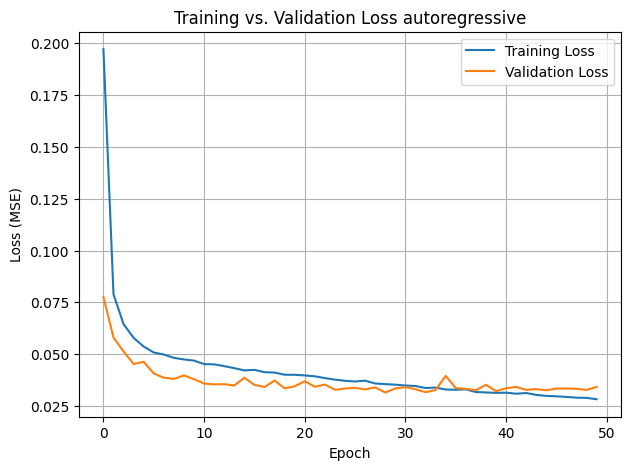

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
rmse: 0.182418, r2: 0.945679 


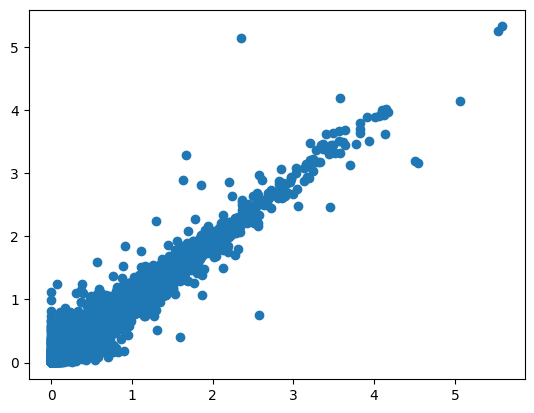

In [20]:


# Extract loss values
train_loss_at= history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day_at= model_at.predict(val_ds_at)# show first few predictions

rmse_1day_at = root_mean_squared_error(y_pred_val_1day_at, val_y_at)
r2_1day_at = r2_score(val_y_at, y_pred_val_1day_at)
print(f'rmse: {rmse_1day_at:3f}, r2: {r2_1day_at:3f} ')
plt.scatter(val_y_at, y_pred_val_1day_at)

In [21]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at, y_val_at = compute_recursive_predictions_fast_LSTM(model_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [22]:
r2_at = r2_score(y_val_at, y_pred_val_at)
rmse_at = root_mean_squared_error(y_val_at, y_pred_val_at)

print(f"r2: {r2_score(y_val_at, y_pred_val_at)}\n rmse: {root_mean_squared_error(y_val_at, y_pred_val_at)}")

r2: 0.20875324375961257
 rmse: 0.7118280418300797


### fine tune model with autoregressive training set 



add cross-validation

In [23]:
# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=32,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# fine tune the model within CV

maes_cv_at_finetune, rmses_cv_at_finetune, rmses_cv_1d_at_finetune, r2s_cv_1d_at_finetune, \
r2s_cv_at_finetune, y_preds_cv_at_finetune, y_trues_cv_at_finetune, historys_cv_at_finetune = cross_validation_LSTM_FT(
    model_ar,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=50,
    batch_size = batch_size
)



Training fold 1/4
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2466 - mae: 0.3444 - rmse: 0.4956 - val_loss: 0.3040 - val_mae: 0.3441 - val_rmse: 0.5506
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1903 - mae: 0.3040 - rmse: 0.4352 - val_loss: 0.3934 - val_mae: 0.3832 - val_rmse: 0.6265
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1691 - mae: 0.2866 - rmse: 0.4102 - val_loss: 0.4506 - val_mae: 0.4032 - val_rmse: 0.6706
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1556 - mae: 0.2738 - rmse: 0.3934 - val_loss: 0.5139 - val_mae: 0.4242 - val_rmse: 0.7163
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1473 - mae: 0.2689 - rmse: 0.3827 - val_loss: 0.5068 - val_mae: 0.4207 - val_rmse: 0.7113
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1408 - mae: 0.2609 - rmse: 0.3740 - val_loss: 0.5520 - val_mae: 0.4358 - val_rmse: 0.7424
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1339 - mae: 0.2566 - 

In [24]:
X_dyn_ar, X_day_ar, X_static_ar, y_ar = build_autoregressive_training_data_fast_LSTM(
    model=model_at,
    df=train_df_at,
    feature_window_size=lag_n,
    label_window_size=1,
    shift=1,
    config=config,
    batch_size=64,
)

ds_ar = tf.data.Dataset.from_tensor_slices(
    ((X_dyn_ar, X_day_ar, X_static_ar), y_ar)
).batch(64).prefetch(tf.data.AUTOTUNE)

In [25]:
# train final model on the full training set with AR-corrupted data
E2 = 50

# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=32,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# now fine-tune on AR-corrupted dataset
model_ar.fit(
    ds_ar,
    epochs=E2,
    validation_data=val_ds_at
)


Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2186 - mae: 0.3015 - rmse: 0.4666 - val_loss: 0.1099 - val_mae: 0.2049 - val_rmse: 0.3302
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1920 - mae: 0.2919 - rmse: 0.4372 - val_loss: 0.1127 - val_mae: 0.2080 - val_rmse: 0.3344
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1830 - mae: 0.2878 - rmse: 0.4268 - val_loss: 0.1117 - val_mae: 0.2076 - val_rmse: 0.3330
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1759 - mae: 0.2834 - rmse: 0.4183 - val_loss: 0.1114 - val_mae: 0.2083 - val_rmse: 0.3324
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1731 - mae: 0.2813 - rmse: 0.4149 - val_loss: 0.1112 - val_mae: 0.2094 - val_rmse: 0.3321
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1704 - mae: 0.2790 - rmse: 0.4117 - val_loss: 0.1173 - val_mae: 0.2145 - val_rmse: 0.3412
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1677 - mae: 0.2770 - rmse:

In [26]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_FT, y_val_at_FT = compute_recursive_predictions_fast_LSTM(model_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [27]:
r2_FT = r2_score(y_val_at_FT, y_pred_val_at_FT)
rmse_FT = root_mean_squared_error(y_val_at_FT, y_pred_val_at_FT)

print(f"r2: {r2_score(y_val_at_FT, y_pred_val_at_FT)}\n rmse: {root_mean_squared_error(y_val_at_FT, y_pred_val_at_FT)}")

r2: 0.13478360413030022
 rmse: 0.7443573682234078


### scheduled sampling - train model

cross validation - implement cross validation

In [28]:
num_epochs = 40

# init model with same architecture
model_at_ar_cv = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=32,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar_cv.set_weights(model_at.get_weights())

maes_cv_at_ar, rmses_cv_at_ar, rmses_cv_1d_at_ar, r2s_cv_1d_at_ar, \
r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar, historys_cv_at_ar = cross_validation_LSTM_AR(
    model_at_ar_cv,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=num_epochs,
    batch_size = batch_size,
    p_min = 0.1,
    warmup_epochs=2,
    frac_decay=0.2)




Training fold 1/4
Epoch 1/40 - loss: 0.0280 - rmse: 0.1645 - val_loss: 0.0814 - val_rmse: 0.2851 - p_tf: 1.000


2025-12-16 19:38:31.001322: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/40 - loss: 0.0237 - rmse: 0.1509 - val_loss: 0.0811 - val_rmse: 0.2846 - p_tf: 1.000
Epoch 3/40 - loss: 0.0218 - rmse: 0.1445 - val_loss: 0.0778 - val_rmse: 0.2786 - p_tf: 1.000
Epoch 4/40 - loss: 0.0224 - rmse: 0.1469 - val_loss: 0.0672 - val_rmse: 0.2586 - p_tf: 0.850
Epoch 5/40 - loss: 0.0299 - rmse: 0.1703 - val_loss: 0.0807 - val_rmse: 0.2839 - p_tf: 0.700
Epoch 6/40 - loss: 0.0333 - rmse: 0.1800 - val_loss: 0.0607 - val_rmse: 0.2459 - p_tf: 0.550
Epoch 7/40 - loss: 0.0365 - rmse: 0.1888 - val_loss: 0.0868 - val_rmse: 0.2945 - p_tf: 0.400
Epoch 8/40 - loss: 0.0490 - rmse: 0.2195 - val_loss: 0.1194 - val_rmse: 0.3460 - p_tf: 0.250
Epoch 9/40 - loss: 0.0998 - rmse: 0.3145 - val_loss: 0.1271 - val_rmse: 0.3570 - p_tf: 0.100


2025-12-16 19:41:07.835806: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/40 - loss: 0.2277 - rmse: 0.4762 - val_loss: 0.2346 - val_rmse: 0.4857 - p_tf: 0.100
Epoch 11/40 - loss: 0.3845 - rmse: 0.6193 - val_loss: 0.4318 - val_rmse: 0.6596 - p_tf: 0.100
Epoch 12/40 - loss: 0.2349 - rmse: 0.4835 - val_loss: 0.3055 - val_rmse: 0.5544 - p_tf: 0.100
Epoch 13/40 - loss: 0.2189 - rmse: 0.4665 - val_loss: 0.4330 - val_rmse: 0.6604 - p_tf: 0.100
Epoch 14/40 - loss: 0.1654 - rmse: 0.4050 - val_loss: 0.2783 - val_rmse: 0.5289 - p_tf: 0.100
Epoch 15/40 - loss: 0.1530 - rmse: 0.3894 - val_loss: 0.3868 - val_rmse: 0.6240 - p_tf: 0.100
Epoch 16/40 - loss: 0.1423 - rmse: 0.3753 - val_loss: 0.2552 - val_rmse: 0.5063 - p_tf: 0.100
Epoch 17/40 - loss: 0.1369 - rmse: 0.3680 - val_loss: 0.4869 - val_rmse: 0.7003 - p_tf: 0.100
Epoch 18/40 - loss: 0.1322 - rmse: 0.3617 - val_loss: 0.3166 - val_rmse: 0.5642 - p_tf: 0.100
Epoch 19/40 - loss: 0.1683 - rmse: 0.4085 - val_loss: 0.4710 - val_rmse: 0.6887 - p_tf: 0.100
Epoch 20/40 - loss: 0.1346 - rmse: 0.3649 - val_loss: 0.3212

2025-12-16 19:46:23.194255: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26/40 - loss: 0.1238 - rmse: 0.3498 - val_loss: 0.5084 - val_rmse: 0.7156 - p_tf: 0.100
Epoch 27/40 - loss: 0.1261 - rmse: 0.3530 - val_loss: 0.3909 - val_rmse: 0.6273 - p_tf: 0.100
Epoch 28/40 - loss: 0.1049 - rmse: 0.3216 - val_loss: 0.4388 - val_rmse: 0.6646 - p_tf: 0.100
Epoch 29/40 - loss: 0.1044 - rmse: 0.3208 - val_loss: 0.3909 - val_rmse: 0.6272 - p_tf: 0.100
Epoch 30/40 - loss: 0.0991 - rmse: 0.3124 - val_loss: 0.3553 - val_rmse: 0.5978 - p_tf: 0.100
Epoch 31/40 - loss: 0.1101 - rmse: 0.3295 - val_loss: 0.3863 - val_rmse: 0.6234 - p_tf: 0.100
Epoch 32/40 - loss: 0.1085 - rmse: 0.3271 - val_loss: 0.2813 - val_rmse: 0.5316 - p_tf: 0.100
Epoch 33/40 - loss: 0.1214 - rmse: 0.3462 - val_loss: 0.5072 - val_rmse: 0.7147 - p_tf: 0.100
Epoch 34/40 - loss: 0.0973 - rmse: 0.3095 - val_loss: 0.3228 - val_rmse: 0.5697 - p_tf: 0.100
Epoch 35/40 - loss: 0.1079 - rmse: 0.3261 - val_loss: 0.4642 - val_rmse: 0.6837 - p_tf: 0.100
Epoch 36/40 - loss: 0.0792 - rmse: 0.2787 - val_loss: 0.3147

Epoch 13/40 - loss: 0.2587 - rmse: 0.5076 - val_loss: 0.3856 - val_rmse: 0.6209 - p_tf: 0.100
Epoch 14/40 - loss: 0.3748 - rmse: 0.6113 - val_loss: 0.3122 - val_rmse: 0.5591 - p_tf: 0.100
Epoch 15/40 - loss: 0.2758 - rmse: 0.5238 - val_loss: 0.2825 - val_rmse: 0.5312 - p_tf: 0.100
Epoch 16/40 - loss: 0.2147 - rmse: 0.4618 - val_loss: 0.2668 - val_rmse: 0.5164 - p_tf: 0.100
Epoch 17/40 - loss: 0.1899 - rmse: 0.4342 - val_loss: 0.1887 - val_rmse: 0.4336 - p_tf: 0.100


2025-12-16 19:59:27.762782: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18/40 - loss: 0.1604 - rmse: 0.3984 - val_loss: 0.1951 - val_rmse: 0.4411 - p_tf: 0.100
Epoch 19/40 - loss: 0.1226 - rmse: 0.3477 - val_loss: 0.1805 - val_rmse: 0.4241 - p_tf: 0.100
Epoch 20/40 - loss: 0.1182 - rmse: 0.3413 - val_loss: 0.2036 - val_rmse: 0.4508 - p_tf: 0.100
Epoch 21/40 - loss: 0.1038 - rmse: 0.3194 - val_loss: 0.1756 - val_rmse: 0.4185 - p_tf: 0.100
Epoch 22/40 - loss: 0.1066 - rmse: 0.3240 - val_loss: 0.1892 - val_rmse: 0.4344 - p_tf: 0.100
Epoch 23/40 - loss: 0.1009 - rmse: 0.3153 - val_loss: 0.1849 - val_rmse: 0.4295 - p_tf: 0.100
Epoch 24/40 - loss: 0.1102 - rmse: 0.3295 - val_loss: 0.1885 - val_rmse: 0.4336 - p_tf: 0.100
Epoch 25/40 - loss: 0.1110 - rmse: 0.3309 - val_loss: 0.2064 - val_rmse: 0.4541 - p_tf: 0.100
Epoch 26/40 - loss: 0.1227 - rmse: 0.3480 - val_loss: 0.2085 - val_rmse: 0.4562 - p_tf: 0.100
Epoch 27/40 - loss: 0.1288 - rmse: 0.3569 - val_loss: 0.2202 - val_rmse: 0.4689 - p_tf: 0.100
Epoch 28/40 - loss: 0.1453 - rmse: 0.3791 - val_loss: 0.2147

2025-12-16 20:32:57.673116: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/40 - loss: 0.0472 - rmse: 0.2142 - val_loss: 0.2110 - val_rmse: 0.4599 - p_tf: 1.000
Epoch 2/40 - loss: 0.0353 - rmse: 0.1847 - val_loss: 0.1966 - val_rmse: 0.4441 - p_tf: 1.000
Epoch 3/40 - loss: 0.0317 - rmse: 0.1748 - val_loss: 0.1772 - val_rmse: 0.4216 - p_tf: 1.000
Epoch 4/40 - loss: 0.0328 - rmse: 0.1779 - val_loss: 0.1692 - val_rmse: 0.4119 - p_tf: 0.850
Epoch 5/40 - loss: 0.0344 - rmse: 0.1828 - val_loss: 0.1601 - val_rmse: 0.4007 - p_tf: 0.700
Epoch 6/40 - loss: 0.0373 - rmse: 0.1907 - val_loss: 0.1546 - val_rmse: 0.3937 - p_tf: 0.550
Epoch 7/40 - loss: 0.0410 - rmse: 0.1999 - val_loss: 0.1505 - val_rmse: 0.3885 - p_tf: 0.400
Epoch 8/40 - loss: 0.0490 - rmse: 0.2194 - val_loss: 0.1580 - val_rmse: 0.3981 - p_tf: 0.250
Epoch 9/40 - loss: 0.0630 - rmse: 0.2493 - val_loss: 0.1697 - val_rmse: 0.4126 - p_tf: 0.100
Epoch 10/40 - loss: 0.0739 - rmse: 0.2702 - val_loss: 0.1773 - val_rmse: 0.4218 - p_tf: 0.100
Epoch 11/40 - loss: 0.0745 - rmse: 0.2710 - val_loss: 0.1862 - val_rm

In [29]:
# now do scheduled sampling training on the full training set
num_epochs = 60

history_ar_at = {
"loss": [],
"rmse": [],
"val_loss": [],
"val_rmse": [],
"p_tf": []
}


# init model with same architecture
model_at_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=32,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar.set_weights(model_at.get_weights())



for epoch in range(num_epochs):
        # train model with teacher forcing for the first epoch 
    p_tf = teacher_forcing_prob(epoch, num_epochs, p0=1.0, p_min=0.1, warmup_epochs=3, frac_decay=0.8)
    history_ar_at["p_tf"].append(p_tf)

    # rebuild AR / scheduled-sampling training data
    X_dyn_ar_at, X_day_ar_at, X_static_ar_at, y_ar_at = build_autoregressive_training_data_fast_LSTM_scheduled(
        model_at_ar,
        train_df_at,
        feature_window_size=lag_n,
        label_window_size=1,
        shift=1,
        config=config,
        batch_size=batch_size,
        teacher_forcing_prob=p_tf,
    )

    train_ds_at_decay = (
        tf.data.Dataset.from_tensor_slices(((X_dyn_ar_at, X_day_ar_at, X_static_ar_at), y_ar_at))
        .shuffle(len(X_dyn_ar_at))
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # one epoch of manual training
    epoch_loss = tf.keras.metrics.Mean()
    epoch_rmse = tf.keras.metrics.RootMeanSquaredError()

    for (x_dyn, x_day, x_stat), y in train_ds_at_decay:
        with tf.GradientTape() as tape:
            preds = model_at_ar([x_dyn, x_day, x_stat], training=True)
            loss = model_at_ar.compute_loss(x=None, y=y, y_pred=preds, sample_weight=None, training=True)

        grads = tape.gradient(loss, model_at_ar.trainable_variables)
        model_at_ar.optimizer.apply_gradients(zip(grads, model_at_ar.trainable_variables))      
        epoch_loss.update_state(loss)
        epoch_rmse.update_state(y, preds)

    # validation
    val_loss_metric = tf.keras.metrics.Mean()
    val_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    for (x_dyn_v, x_day_v, x_stat_v), y_v in val_ds_at:
        preds_v = model_at_ar([x_dyn_v, x_day_v, x_stat_v], training=False)
        v_loss = model_at_ar.compute_loss(x=None, y=y_v, y_pred=preds_v, sample_weight=None, training=False)
        val_loss_metric.update_state(v_loss)
        val_rmse_metric.update_state(y_v, preds_v)

    history_ar_at["loss"].append(epoch_loss.result().numpy())
    history_ar_at["rmse"].append(epoch_rmse.result().numpy())
    history_ar_at["val_loss"].append(val_loss_metric.result().numpy())
    history_ar_at["val_rmse"].append(val_rmse_metric.result().numpy())
    history_ar_at["p_tf"].append(p_tf)

    print(
        f"Epoch {epoch+1}/{num_epochs} - "
        f"loss: {history_ar_at['loss'][-1]:.4f} - rmse: {history_ar_at['rmse'][-1]:.4f} - "
        f"val_loss: {history_ar_at['val_loss'][-1]:.4f} - val_rmse: {history_ar_at['val_rmse'][-1]:.4f} - "
        f"p_tf: {p_tf:.3f}"
    )

Epoch 1/60 - loss: 0.0280 - rmse: 0.1647 - val_loss: 0.0334 - val_rmse: 0.1804 - p_tf: 1.000
Epoch 2/60 - loss: 0.0269 - rmse: 0.1613 - val_loss: 0.0341 - val_rmse: 0.1824 - p_tf: 1.000
Epoch 3/60 - loss: 0.0267 - rmse: 0.1607 - val_loss: 0.0349 - val_rmse: 0.1845 - p_tf: 1.000
Epoch 4/60 - loss: 0.0266 - rmse: 0.1604 - val_loss: 0.0335 - val_rmse: 0.1808 - p_tf: 1.000
Epoch 5/60 - loss: 0.0265 - rmse: 0.1601 - val_loss: 0.0343 - val_rmse: 0.1829 - p_tf: 0.980
Epoch 6/60 - loss: 0.0279 - rmse: 0.1644 - val_loss: 0.0344 - val_rmse: 0.1834 - p_tf: 0.960
Epoch 7/60 - loss: 0.0274 - rmse: 0.1630 - val_loss: 0.0337 - val_rmse: 0.1815 - p_tf: 0.940
Epoch 8/60 - loss: 0.0282 - rmse: 0.1653 - val_loss: 0.0334 - val_rmse: 0.1805 - p_tf: 0.920
Epoch 9/60 - loss: 0.0272 - rmse: 0.1626 - val_loss: 0.0337 - val_rmse: 0.1815 - p_tf: 0.900
Epoch 10/60 - loss: 0.0270 - rmse: 0.1620 - val_loss: 0.0347 - val_rmse: 0.1842 - p_tf: 0.880
Epoch 11/60 - loss: 0.0278 - rmse: 0.1640 - val_loss: 0.0342 - val_rm

In [30]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_ar, y_val_at_ar= compute_recursive_predictions_fast_LSTM(model_at_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_at_ar = r2_score(y_val_at_ar, y_pred_val_at_ar)
rmse_at_ar = root_mean_squared_error(y_val_at_ar, y_pred_val_at_ar)

print(f"r2: {r2_at_ar}\n rmse: {rmse_at_ar}")

r2: -1.1337121447828173
 rmse: 1.1689260466330762


In [31]:
# plot performance together

df_model_performance = pd.DataFrame({
    "model" :['teacher_forcing (hidden=16)'] *4 + ['teacher_forcing (hidden=32)'] *4 + ['fine_tuned (hidden=32)'] *4 + ['scheduled_sampling (hidden=32)'] *4,    
    "cv_fold"  : [i for i in range(1, len(maes_cv_at_ar) + 1)] *4,
    "mae": maes_cv_at + maes_cv_at2 + maes_cv_at_finetune + maes_cv_at_ar,
    "rmse_recursive": rmses_cv_at + rmses_cv_at2 + rmses_cv_at_finetune + rmses_cv_at_ar,
    "rmse_1day": rmses_cv_1d_at + rmses_cv_1d_at2 + rmses_cv_1d_at_finetune + rmses_cv_1d_at_ar,
    "r2_1day" : r2s_cv_1d_at + r2s_cv_1d_at2 + r2s_cv_1d_at_finetune + r2s_cv_1d_at_ar,
    "r2_recursive": r2s_cv_at + r2s_cv_at2 + r2s_cv_at_finetune + r2s_cv_at_ar,
}
)

df_model_p_long = df_model_performance.melt(id_vars=["model", "cv_fold"], 
                                        value_vars=["mae", "rmse_recursive", "rmse_1day", "r2_1day", "r2_recursive"],
                                        var_name="metric",
                                        value_name="value"
                                        )

In [32]:
df_model_p_long 

,model,cv_fold,metric,value
0,teacher_forcing (hidden=16),1,mae,0.221835
1,teacher_forcing (hidden=16),2,mae,0.212752
2,teacher_forcing (hidden=16),3,mae,0.113799
3,teacher_forcing (hidden=16),4,mae,0.168051
4,teacher_forcing (hidden=32),1,mae,0.349140
...,...,...,...,...
75,fine_tuned (hidden=32),4,r2_recursive,0.129929
76,scheduled_sampling (hidden=32),1,r2_recursive,-0.493348
77,scheduled_sampling (hidden=32),2,r2_recursive,0.210298
78,scheduled_sampling (hidden=32),3,r2_recursive,0.095927


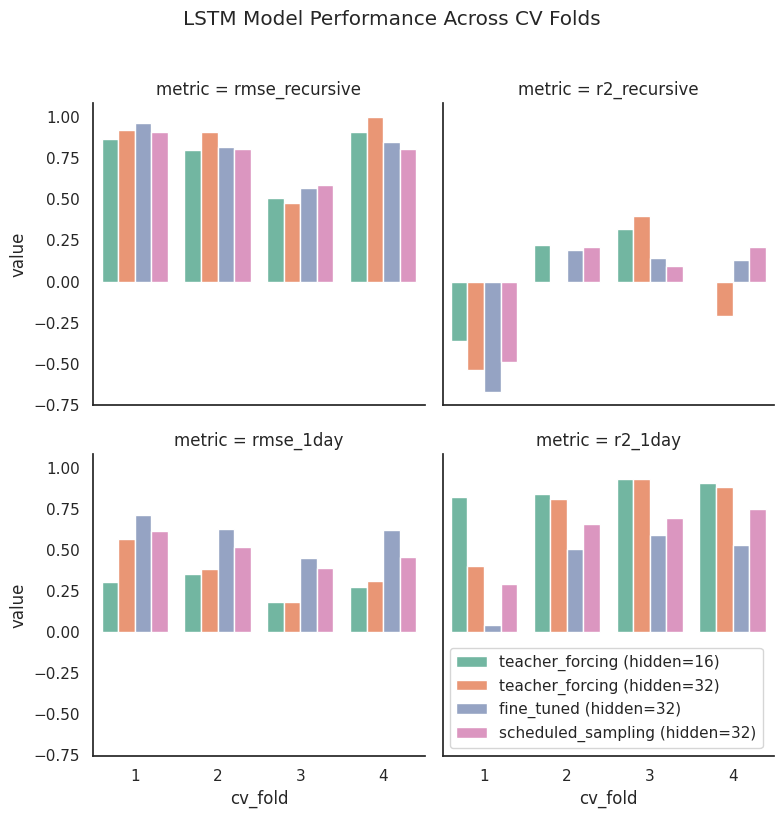

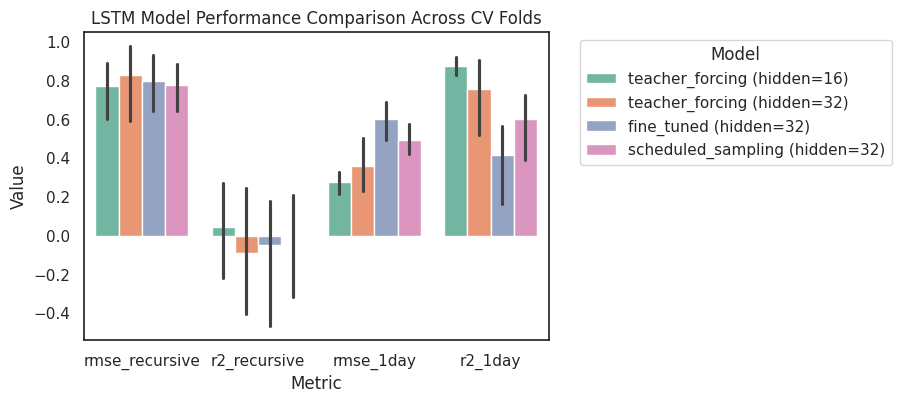

In [33]:
sns.set(style="white", font_scale=1,
        rc={"figure.figsize": (6, 4)})

metrics_plot = ['rmse_recursive', 'r2_recursive', 'rmse_1day', 'r2_1day']
df_p_plot = df_model_p_long.loc[df_model_p_long['metric'].isin(
metrics_plot
)]  
g = sns.FacetGrid(df_p_plot, col="metric", col_wrap = 2,
              col_order = metrics_plot,
              height=4, sharey=True).map_dataframe(
    sns.barplot,
    x="cv_fold",
    y="value",
    hue = 'model',
    palette = "Set2",
    legend = True,
)

g.figure.suptitle("LSTM Model Performance Across CV Folds", y=1.02)


plt.tight_layout()
plt.legend()
plt.show()

sns.barplot(df_p_plot, x="metric", y="value", hue="model", palette="Set2",
            order = metrics_plot)
plt.title("LSTM Model Performance Comparison Across CV Folds")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1))
plt.show()


/tmp/ipykernel_5571/2033151881.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/tmp/ipykernel_5571/2033151881.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_5571/2033151881.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_5571/2033151881.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


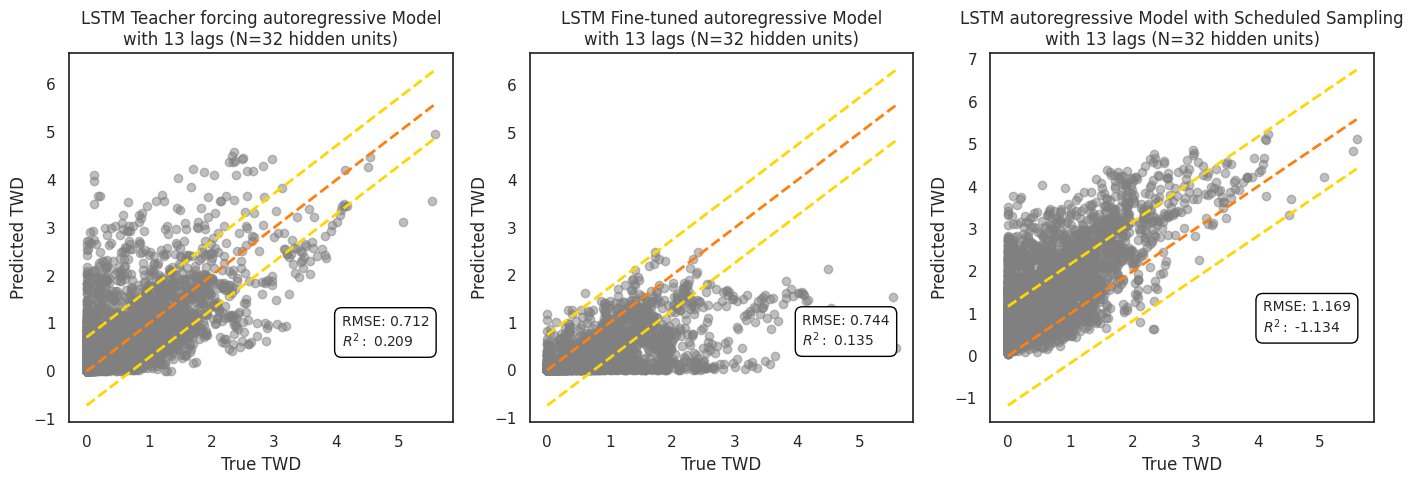

In [34]:
# Create figure with 3 subplots showing model final performance

def ensure_numpy(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()
    return np.asarray(x)
y_val_at = ensure_numpy(y_val_at).reshape(-1)
y_pred_val_at = ensure_numpy(y_pred_val_at).reshape(-1)
# val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(14, 5))


# First subplot - Autoregressive Model Predictions hidden 32
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [y_val_at.min(), y_val_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"LSTM Teacher forcing autoregressive Model\nwith {lag_n} lags (N=32 hidden units)")
ax1.text(y_val_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# plot fine-tuned 
ax2.scatter(x =  y_val_at_FT, y = y_pred_val_at_FT, color="grey", alpha=0.5)
ax2.set_xlabel("True TWD")
ax2.set_ylabel("Predicted TWD")
x_range = [y_val_at_FT.min(), y_val_at_FT.max()]
ax2.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax2.plot(x_range, [i+rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.plot(x_range, [i-rmse_FT for i in x_range], 'k--', lw=2, color="gold")
ax2.set_title(f"LSTM Fine-tuned autoregressive Model\nwith {lag_n} lags (N=32 hidden units)")
ax2.text(y_val_at_FT.max()-1.5,y_pred_val_at_FT.min()+0.5, 
         f"RMSE: {rmse_FT:.3f}\n$R^2:$ {r2_FT:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))   


# plot scheduled sampling 
ax3.scatter(x = y_val_at_ar, y = y_pred_val_at_ar, color="grey", alpha=0.5)
ax3.set_xlabel("True TWD")
ax3.set_ylabel("Predicted TWD")
x_range = [y_val_at_ar.min(), y_val_at_ar.max()]
ax3.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax3.plot(x_range, [i+rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.plot(x_range, [i-rmse_at_ar for i in x_range], 'k--', lw=2, color="gold")
ax3.set_title(f"LSTM autoregressive Model with Scheduled Sampling\nwith {lag_n} lags (N=32 hidden units)")
ax3.text(y_val_at_ar.max()-1.5,y_pred_val_at_ar.min()+0.5, 
         f"RMSE: {rmse_at_ar:.3f}\n$R^2:$ {r2_at_ar:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  

plt.tight_layout()
plt.show()



why the performance is so bad ..
- try the same on ridge regression?

to improve the model performance
- we can try to improve the LSTM architecture 
    -  added softplus - why it lowered the performance? 
    - play with the architecture and hyperparameter
- add also compute the correlation matrix of lagged features with twd
- should I create cross-validation function to choose the tune the model?
- how can i integrate autoregressive training?
- incorporate log value into traning 
- stack layers? 
- how to extrapolate if i use location and other static parameters in the future?
- perturbation to analyze feature importance